<a href="https://colab.research.google.com/github/veryHapppy/study_ai/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna
#!pip install catboost
#!pip install category_encoders
from urllib.request import urlopen
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
import shap

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 전처리

In [ ]:
# Data Preprocessing : 데이터 전처리
# Garbage In, Garbage Out

In [ ]:
#titanic data 저장하기
with open("titanic.csv", "w", encoding="UTF8") as f:
    resp = urlopen('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
    f.write(resp.read().decode('utf-8'))

In [ ]:
# 1.결측치 처리 (Missing Value)
data = pd.read_csv("titanic.csv")
print(data.isnull().sum()) # 컬럼별로 빈 값 개수 확인

#data = data.dropna(subset=['Cabin']) # 비어있는 행 삭제
data['Age'] = data['Age'].fillna(data['Age'].median()) # 중앙값으로 대체
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0]) #최빈값으로 대체



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# 2. 이상치 처리
# 박스 플롯을 그려서 이상치 확인
# 보통 기준을 Q3-Q1의 1.5배로 설정, 상한선과 하한선을 둠
Q1 = data['Fare'].quantile(0.25)
Q3 = data['Fare'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + IQR * 1.5

data['Fare'] = np.where(data['Fare'] > upper_limit, upper_limit, data['Fare']) # 상한선을 넘는 값은 상한선 값으로 조정


In [ ]:
# 3. 피처 엔지니어링
# 기존 데이터로 학습하기 좋은 데이터를 만듦
# titanic의 SibSp(형제, 배우자 수)와 Parch(부모, 자녀 수)를 합쳐 FamilySize를 만듦
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [ ]:
# 4. 인코딩
# 글자를 숫자로 바꿈
# 레이블 인코딩 : 카테고리별로 고유한 숫자 부여 - 모델이 숫자 값을 의미있게 받아들일 수도 있음
# 원-핫 인코딩 : 각 카테고리를 새로운 열로 만들고 해당하는 카테고리인 경우만 1, 아니면 0
#                항목이 많아지면 컬럼 수가 급격히 증가
# sex의 male, female을 숫자로 변경

# 레이블 인코딩 / 알파벳 순서로 정수로 변환
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

# 원-핫 인코딩 / embarked_C, embarked_Q, embarked_S 생성
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)
# drop_first : 첫번째 생성되는 열을 없앰 -> 선형 모델에서는 필요 (다중공선성 방지)

In [ ]:
# 5. 스케일링
# 숫자 범위를 일정한 기준으로 맞추는 작업
# 모델이 숫자가 전체적으로 큰 컬럼을 중요한 데이터로 착각할 수 있음

# 표준화 (Standardization) : 0 ~ 1, 분포모양 유지
std_scaler = StandardScaler()
data['Age_std'] = std_scaler.fit_transform(data[['Age']])

# 정규화 (Normalization) : 평균 0, 표준편차 1
# 이상치가 많을 때 안정적
mm_scaler = MinMaxScaler()
data['Fare_minmax'] = mm_scaler.fit_transform(data[['Fare']])

In [ ]:
# 6. 결과 확인
columns_to_drop = ['PassengerId','Pclass','Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age','Fare']
data_final = data.drop(columns=columns_to_drop)

print("--- 전처리 완료된 데이터")
print(data_final.head())

--- 전처리 완료된 데이터
   Survived  Sex  FamilySize  Embarked_Q  Embarked_S   Age_std  Fare_minmax
0         0    1           2       False        True -0.565736     0.110460
1         1    0           2       False       False  0.663861     1.000000
2         1    0           1       False        True -0.258337     0.120745
3         1    0           2       False        True  0.433312     0.809027
4         0    1           1       False        True  0.433312     0.122649


# 고급 기법

In [ ]:
# 1. 차원 축소 (Dimension Reduction)
# PCA : 주성분 분석, 여러 변수의 특징을 추출하여 중요한 몇개의 변수로 합치는 기술
# 적용 전에 스케일링 필수

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Age', 'Fare', 'FamilySize']]) # 스케일링

pca = PCA(n_components=2) # 주성분 개수, n_components에 보존하고 싶은 정보량의 비율을 넣을 수 있음
data_pca = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])

# 원본 데이터의 정보 설명력 확인, 보통 각 행의 비율을 더했을 때 70~90% 이상이면 OK
# 시각화가 목적이면 2 or 3개로 고정
print(pca.explained_variance_ratio_)

[0.46358827 0.37663531]


In [ ]:
#!pip install imbalanced-learn

In [ ]:
# 2. 불균형 데이터 처리
# 특정 클래스의 데이터가 다른 클래스에 비해 압도적으로 많거나 적을때 진행
# 언더샘플링 / 오버샘플링 : SMOTE(소수 데이터의 특징으로 가상의 데이터를 만들어냄)

# x : Feature, 모델이 학습할 데이터
# y : Target, 정답 데이터
x = data_final.drop('Survived', axis=1)
y = data_final['Survived']

#random_state : 랜덤 결과를 일정하게 함, 0 ~ 100이면 상관X
smote = SMOTE(random_state=42)

# 생존자, 사망자의 데이터 개수를 맞춤 (소수 데이터를 만들어냄)
x_resampled, y_resampled = smote.fit_resample(x, y)

print(f"변환 전 정답 분포:\n{y.value_counts()}")
print(f"변환 후 정답 분포:\n{y_resampled.value_counts()}")

변환 전 정답 분포:
Survived
0    549
1    342
Name: count, dtype: int64
변환 후 정답 분포:
Survived
0    549
1    549
Name: count, dtype: int64


# 모델 학습

In [ ]:
# 데이터 나누기

# 8:2로 분리 (데이터가 만개가 넘으면 10%만 써도 괜찮음)
# stratify=y_resampled : 정답 데이터의 비율을 유지
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
# 모델 생성 (결정트리 모델 사용)
#model = DecisionTreeClassifier(random_state=42)
# 랜덤 포레스트 모델 : 결정트리를 여러개 사용(100개)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#모델 평가

# 예측하기
y_pred = model.predict(x_test)

# 채점
accuracy = accuracy_score(y_test, y_pred)
print(f"모델의 예측 정확도: {(accuracy * 100):.2f}%")

모델의 예측 정확도: 85.00%


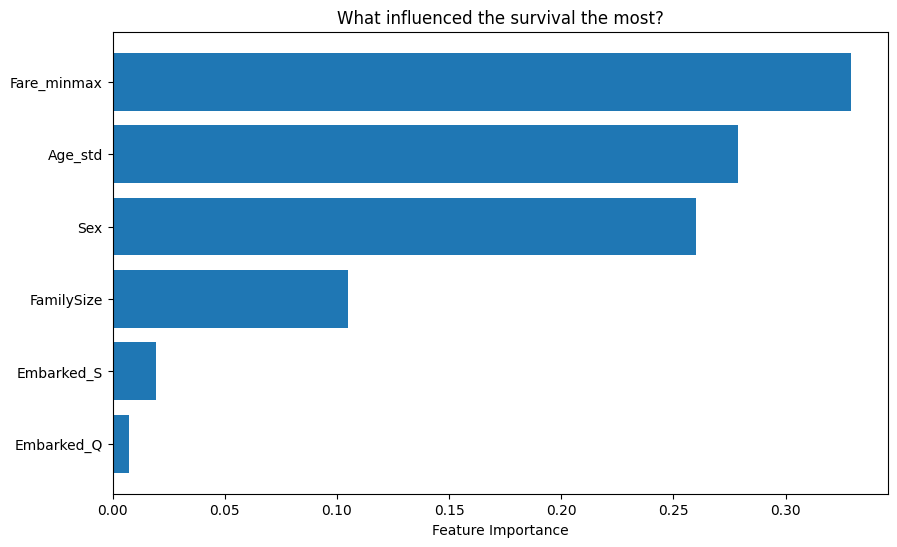

In [ ]:
# 중요한 컬럼 시각화

importances = model.feature_importances_
feature_names = x.columns

# 가로 10인치, 세로 6인치 그래프 창 생성
plt.figure(figsize=(10, 6))
indices = np.argsort(importances)
# 가로 막대그래프 생성
plt.barh(range(len(indices)), importances[indices], align='center')
# y축 눈금에 컬럼 이름 작
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('What influenced the survival the most?')
plt.show()

# GridSearchCV

In [ ]:
# 하이퍼파라미터
# 모델의 설정값을 최적으로 맞추는 과정
# 설정값의 후보를 던져주면 테스트 후 가장 좋은 모델 사용

# n_estimators : 랜덤 포레스트에서 결정 트리 개수
# max_depth : 최대 깊이 (너무 깊으면 과적합 발생)
# min_samples_split : 노드를 분할하기 위한 최소한의 데이터 수 (노드가 너무 많아 지는 것을 방지)
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# cv : train 데이터를 5등분해서 하나를 테스트로 사용, 5번 반복 (8:2 비율 유지)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

#test 데이터 없이도 내부적으로 성능 측정 가능
grid_search.fit(x_train, y_train)

print(f"최적의 설정값: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.2f}")

최적의 설정값: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 25}
최고 정확도: 0.82


# *pipeline

In [ ]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # 정규표현식으로 호칭 추출
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        # 호칭 단순화
        rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        X['Title'] = X['Title'].replace(rare_titles, 'Rare')
        X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X['Title'] = X['Title'].replace('Mme', 'Mrs')

        # 'Name' 컬럼은 이제 필요 없으므로 삭제 (Title 컬럼만 남김)
        return X.drop(['Name'], axis=1)

# 1. 데이터 로드 및 기본 정리
df = pd.read_csv('train.csv')

# 학습에 사용할 핵심 특성만 선택
features = ['Name', 'Age', 'Fare', 'Embarked', 'Sex', 'Pclass']
X = df[features]
y = df['Survived']

# 데이터 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 수치형 데이터 전처리 공정 (나이, 요금, 객실등급)
num_features = ['Age', 'Fare', 'Pclass']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # 빈칸은 중앙값으로
    ('scaler', StandardScaler())                   # 표준화 스케일링
])

# 3. 범주형 데이터 전처리 공정 (항구, 성별)
cat_features = ['Embarked', 'Sex', 'Title']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # 빈칸은 최빈값으로
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))    # 원-핫 인코딩
])

# 4. 전처리 도구 통합 (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 5. 전체 파이프라인 구축 (전처리 + 모델)
full_pipeline = Pipeline(steps=[
    ('title_ext', TitleExtractor()), # 1단계: 이름에서 호칭 뽑기
    ('preprocessor', preprocessor),   # 2단계: 나머지 수치/범주형 전처리
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 6. 학습 시작 (원본 데이터를 그대로 넣음)
full_pipeline.fit(X_train, y_train)

# 7. 성능 확인
score = full_pipeline.score(X_test, y_test)
print(f"테스트 데이터 정확도: {score:.4f}")

# 8. 파이프라인 전체 저장
joblib.dump(full_pipeline, 'titanic_model_pipeline.pkl')
print("파이프라인 저장 완료")



FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

# *Optuna

In [ ]:
# Optuna : 테스트를 바탕으로 모델이 알아서 설정값을 바꿈
# objective 함수 : 어떤 모델, 어떤 다이얼을 돌릴지 정의
# trial : 한번의 시도
# study : 최적화 과정 전체
#!pip install optuna

def objective(trial):
    # 1. 시도해볼 다이얼 범위 지정 (trial.suggest_...)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'verbose': -1
    }

    # 2. 모델 설정
    model = LGBMClassifier(**params, random_state=42)

    # 3. 교차 검증 점수를 계산 (이 점수가 높아야 함)
    # 파이프라인 안에 넣어 사용하면 전처리까지 포함됩니다.
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('m', model)])
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

# 4. 최적화 실행
study = optuna.create_study(direction='maximize') # 점수를 최대화하는 방향으로
study.optimize(objective, n_trials=50) # 50번 시도

print(f"최고 점수: {study.best_value:.4f}")
print(f"최적 파라미터: {study.best_params}")

[I 2025-12-22 10:26:16,588] A new study created in memory with name: no-name-88122437-3973-47b8-b881-adeef04e2ded
[W 2025-12-22 10:26:16,595] Trial 0 failed with parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.04970365298053341, 'num_leaves': 48, 'min_child_samples': 29} because of the following error: NameError("name 'preprocessor' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1701107397.py", line 23, in objective
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('m', model)])
                                                ^^^^^^^^^^^^
NameError: name 'preprocessor' is not defined
[W 2025-12-22 10:26:16,605] Trial 0 failed with value None.


NameError: name 'preprocessor' is not defined

In [ ]:
# 튜닝 (하이퍼파라미터)
# 별명__설정값 이름

param_grid = {
    'classifier__n_estimators' : [100, 200, 300],
    'classifier__max_depth' : [None, 5, 10, 20],
    'classifier__min_samples_split' : [2, 5, 10],
    'preprocessor__num__imputer__strategy': ['mean', 'median'] # 전처리 과정의 설정도 변경 가능
}

# 학습 n_jobs : 병렬로 사용할 CPU 수, verbose : 학습 중 보고 방식(숫자가 클수록 자주 보고함)
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 결과
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# 최종 테스트
final_score = best_model.score(X_test, y_test)
print(f"최종 실전 정확도: {final_score:.4f}")

# 저장
joblib.dump(best_model, 'titanic_best_pipeline.pkl')

# Load

In [ ]:
import joblib
import pandas as pd

# 저장된 파일 불러오기
loaded_model = joblib.load('titanic_best_pipeline.pkl')

new_passenger = pd.DataFrame({
    'age': [25],
    'fare': [50.0],
    'embarked': ['S'],
    'sex': ['female'],
    'pclass': [1]
})

prediction = loaded_model.predict(new_passenger)
probability = loaded_model.predict_proba(new_passenger)
print(probability)

# 3. 결과 출력
print("-" * 30)
if prediction[0] == 1:
    print(f"예측 결과: [ 생존 ]")
    print(f"생존 확률: {probability[0][1]*100:.2f}%")
else:
    print(f"예측 결과: [ 사망 ]")
    print(f"사망 확률: {probability[0][0]*100:.2f}%")
print("-" * 30)


# ensemble

앙상블 만드는 과정
1. 개별 모델 튜닝 : 각각의 모델에 대해 최적의 파라미터를 찾음
2. 가중치 부여 : 모델의 실력에 따라 가중치 부여
3. VotingClassifier, StackingClassifier로 묶음

In [ ]:
# 앙상블 구현 (XGBoost, LightGBM)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model = LGBMClassifier(n_estimators=100,   # 결정 트리의 개수 (많으면 과적합, 적으면 성능이 안나옴)
                            learning_rate=0.05, # 이전 트리의 오차를 반영하는 학습률 (0.01~0.1)
                                                # 보통 n_esitimators와 반비례로 밸런스 조절
                            num_leaves=31,      # 트리 하나가 가질 수 있는 leaf node의 개수 (<2^(max_depth))
                            random_state=42,
                            verbose=-1
                            )

voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    #weights=[2,1] # XGBoost에 두배의 가중치 제공
    voting='soft') # soft : 확률을 평균내서 결정, hard : 다수결로 결정

# 파이프라인 구축
ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_model', voting_model)
])

# 학습
ensemble.fit(X_train, y_train)

# 평가
print(f"{ensemble.score(X_test, y_test):.4f}")

# 저장
joblib.dump(ensemble, 'titanic_ensemble.pkl')

# + CatBoost

In [ ]:
# CatBoost : 범주형 변수를 처리하는데 특화 (성별, 직업, 혈액형 등)
# 문자열을 넣어도 내부적으로 숫자로 변환
# 결정 트리를 만들 때 왼쪽과 오른쪽 자식 노드를 항상 같은 조건으로 분할 (대칭 트리)
# 튜닝할 시간이 없을 때처럼 기본값 성능이 가장 좋음
# !pip install catboost

cat_model = CatBoostClassifier(
    iterations=500,        # == n_estimators
    learning_rate=0.05,    # 학습률
    depth=6,               # 트리 깊이
    random_seed=42,
    verbose=0              # 중간 학습 과정 생략
)

voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cat', cat_model)
    ],
    voting='soft')

# 파이프라인 구축
ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_model', voting_model)
])

# 학습
ensemble.fit(X_train, y_train)

# 평가
print(f"{ensemble.score(X_test, y_test):.4f}")

# 저장
joblib.dump(ensemble, 'titanic_three_model_ensemble.pkl')

# Stacking

In [ ]:
# stacking : 모델들의 예측값을 입력 데이터로 사용 -> 메타 모델이 최종 결정을 내림
# 메타 모델이 복잡하면 과적합 확률이 매우 커짐, 단순한 로지스틱 회귀 모델을 주로 사


base_model = [
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cat', cat_model)
]

stacking_model = StackingClassifier(
    estimators = base_model,
    final_estimator = LogisticRegression(),
    cv = 5
)


stacking_ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking_model', stacking_model)
])

stacking_ensemble.fit(X_train, y_train)

final_score = stacking_ensemble.score(X_test, y_test)
print(f"최종 실전 정확도: {final_score:.4f}")

# 저장
joblib.dump(best_model, 'titanic_best_pipeline.pkl')

# *Optuna + (voting, stacking)

In [ ]:


def objective(trial):
    # 1. 각 모델별 다이얼 범위 설정
    # XGBoost 파라미터
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n', 50, 200),
        'max_depth': trial.suggest_int('xgb_depth', 3, 7),
        'colsample_bytree': trial.suggest_float('xgb_colsample', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('xgb_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('xgb_lambda', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.1),
    }

    # LightGBM 파라미터
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n', 50, 200),
        'num_leaves': trial.suggest_int('lgbm_leaves', 15, 50),
        'learning_rate': trial.suggest_float('lgbm_lr', 0.01, 0.1),
        'verbose': -1
    }

    # CatBoost 파라미터
    cat_params = {
        'iterations': trial.suggest_int('cat_iter', 50, 200),
        'depth': trial.suggest_int('cat_depth', 3, 7),
        'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'verbose': 0
    }

    # 2. 모델간 가중치(Weight) 설정
    w_xgb = trial.suggest_float('w_xgb', 0.5, 2.0) # 0.5~2.0 사이의 실수
    w_lgbm = trial.suggest_float('w_lgbm', 0.5, 2.0)
    w_cat = trial.suggest_float('w_cat', 0.5, 2.0)

    # 3. 모델 객체 생성
    xgb = XGBClassifier(**xgb_params, random_state=42)
    lgbm = LGBMClassifier(**lgbm_params, random_state=42)
    cat = CatBoostClassifier(**cat_params, random_state=42)

    # 4. 앙상블 모델 구축
    voting_model = VotingClassifier(
        estimators=[('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
        voting='soft',
        weights=[w_xgb, w_lgbm, w_cat]
    )

    # 5. 파이프라인 연결 및 평가
    pipeline = Pipeline(steps=[
        ('title_ext', TitleExtractor()),
        ('preprocessor', preprocessor),
        ('ensemble', voting_model)
    ])

    # 교차 검증으로 점수 측정 (과적합 방지를 위해 5-Fold 사용)
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

# 6. 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70) # 시도 횟수

print(f"최고 정확도: {study.best_value:.4f}")
for i in study.best_params:
    print(f"{i}: {study.best_params[i]}")

In [ ]:
best = study.best_params

xgb_final = XGBClassifier(
    n_estimators=best['xgb_n'],
    max_depth=best['xgb_depth'],
    learning_rate=best['xgb_lr'],
    colsample_bytree=best['xgb_colsample'],
    reg_alpha=best['xgb_alpha'],
    reg_lambda=best['xgb_lambda'],
    random_state=42
)

lgbm_final = LGBMClassifier(
    n_estimators=best['lgbm_n'],
    num_leaves=best['lgbm_leaves'],
    learning_rate=best['lgbm_lr'],
    random_state=42,
    verbose=-1
)

cat_final = CatBoostClassifier(
    iterations=best['cat_iter'],
    depth=best['cat_depth'],
    learning_rate=best['cat_lr'],
    l2_leaf_reg=best['l2_leaf_reg'],
    random_strength=best['random_strength'],
    random_state=42,
    verbose=0
)

# voting 방식
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgbm', lgbm_final),
        ('cat', cat_final)
    ],
    voting='soft',
    weights=[best['w_xgb'], best['w_lgbm'], best['w_cat']]
)

#stacking 방식
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgbm', lgbm_final),
        ('cat', cat_final)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

final_voting_pipeline = Pipeline(steps=[
    ('title_ext', TitleExtractor()),
    ('preprocessor', preprocessor),
    ('model', voting_model)
])
final_stacking_pipeline = Pipeline(steps=[
    ('title_ext', TitleExtractor()),
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

final_voting_pipeline.fit(X_train, y_train)
final_stacking_pipeline.fit(X_train, y_train)

print(f"voting 검증 점수: {final_voting_pipeline.score(X_test, y_test):.4f}")
print(f"stacking 검증 점수: {final_stacking_pipeline.score(X_test, y_test):.4f}")

# 6. 모델 저장
joblib.dump(final_voting_pipeline, 'titanic_voting_best.pkl')
joblib.dump(final_stacking_pipeline, 'titanic_stacking_best.pkl')
print("저장되었습니다")


# 정확도 높이기

In [ ]:
# Target Encoding
# 범주형 변수의 각각의 범주를 타겟값 평균으로 변환
# 원핫 인코딩의 변수가 늘어나는 단점을 해결
# smoothing = (해당 그룹의 데이터 수 * 그룹 평균 + 스무딩 계수 * 전체 평균)  /  (해당 그룹의 데이터 수 + 스무딩 계수)
# -> 데이터가 적은 범주는 전체 평균에 가깝게 변환

# 일반적인 학습
encoder = TargetEncoder(cols=['HomePlanet', 'Deck'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# pipeline
Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # 'onehot' 대신 'target'
    ('target', TargetEncoder(smoothing=10))
])

# Optuna
smoothing = trial.suggest_int('smoothing', 5, 50)
encoder = TargetEncoder(cols=cat_features, smoothing=smoothing)

In [ ]:
# feature interaction
# 단순히 여러 변수를 모델에 넘겨주는게 아닌
# 변수들의 관계를 이용해 새로운 변수를 생성
# 더 좋은 정보력을 가진 변수를 줌

# 1. 범주형 + 번주형 (문자열 합치기
df['Planet_Cryo'] = df['HomePlanet'] + '_' + df['CryoSleep'].astype(str)
# 2. 범주형 + 수치형 조합 (조건부 통계량)
# 예: 각 행성별 평균 지출액 대비 본인의 지출 비중
df['Spending_Relative_to_Planet'] = df['TotalSpending'] / (df.groupby('HomePlanet')['TotalSpending'].transform('mean') + 1)

# 3. 이진형 + 이진형 (논리 연산)
# 돈을 한 푼도 안 쓰고 동면 중인 '안전한' 승객군
df['Safe_Passenger'] = ((df['IsSpender'] == 0) & (df['CryoSleep'] == True)).astype(int)


In [ ]:
# Stratified K-Fold (계층적 K겹 교차 검증)
# train과 test의 점수 차이를 줄이는 방법
# 정답 비율을 유지하며 뭉치를 나눔
# K개로 나누어 K번의 학습

# Classification
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# optuna objective 함수 안에서
# cv = 5 대신 cv = skf
score = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy').mean()

# Regression (계층별로 못 나누고, 무작위로 분)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# OOF (Out-of-Fold)
# 모델을 학습시키는 과정에서 학습 데이터를 쪼개 학습용과 검증용을 나눔
# 5개로 나누면 1개가 검증용, 5번의 학습 진행

stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgbm', lgbm_final),
        ('cat', cat_final)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
# optuna를 진행하고 모델을 학습시킬때 StackingClassifier에서 cv=5로 사용 중


# 과적합 평가 (학습곡선)

In [ ]:
def plot_learning_curve(estimator, X, y):
    # 훈련 데이터 양을 5단계로 나누어 실험
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy'
    )

    # 평균과 표준편차 계산
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 그래프 그리기
    plt.figure(figsize=(12, 7))
    plt.ylim(0.7, 1.02)
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    for i, txt in enumerate(train_mean):
        plt.text(train_sizes[i], train_mean[i] + 0.005, f'{txt:.4f}',
                 color='red', fontweight='bold', ha='center', va='bottom')

    for i, txt in enumerate(test_mean):
        plt.text(train_sizes[i], test_mean[i] - 0.015, f'{txt:.4f}',
                 color='green', fontweight='bold', ha='center', va='top')

    # 오차 범위 표시 (색칠)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
plot_learning_curve(final_stacking_pipeline, X_train, y_train)

# 변수 중요도 확인

In [ ]:

def plot_feature_importance(model, feature_names, model_name):
    # 중요도 추출
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # 가끔 모델에 따라 다른 속성명을 가질 수 있음
        importances = model.get_feature_importances() if hasattr(model, 'get_feature_importances') else None

    if importances is None:
        print(f"{model_name} 모델은 중요도를 지원하지 않습니다.")
        return

    # 데이터프레임 생성
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance - {model_name}')
    plt.show()



In [ ]:
# (One-Hot Encoding 때문에 컬럼 수가 늘어났을 수 있으므로 전처리기에서 추출해야 함)
feature_names = final_voting_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 앙상블 내부의 각 모델 중요도 확인
voting_model = final_voting_pipeline.named_steps['model']


plot_feature_importance(voting_model.named_estimators_['xgb'], feature_names, "XGBoost")

plot_feature_importance(voting_model.named_estimators_['lgbm'], feature_names, "LightGBM")

plot_feature_importance(voting_model.named_estimators_['cat'], feature_names, "CatBoost")

In [ ]:
# SHAP Summary Plot
# 각 피처의 기여도 확인
# 위에서 부터 중요도가 높은 순서
# 빨간색이 값이 큰 경우
# 오른쪽(양수)가 결과값이 양수 확률을 높임
# 점이 많이 뭉쳐있음 -> 해당 값이 많음
# feature_importances_보다 좋은데 느림

model = pipeline.named_steps['model']
xgb = model.named_estimators_['xgb']

# 전처리기를 거친 데이터를 미리 준비해야 합니다.
X_transformed = final_stacking_pipeline.named_steps['preprocessor'].transform(test_data)
feature_names = final_stacking_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 2. Explainer 생성
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_transformed)

# 3. 요약 그래프 (어떤 피처가 전체적으로 중요한가?)
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

# Kaggle 제출하기

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/spaceship_titanic_test.csv')
test_data = feature_engineering(test)
test_data['TotalSpending_log'] = np.log1p(test_data['TotalSpending'])

features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep', 'GroupSize', 'TotalSpending_log', 'IsSpender', 'AgeGroup', 'Cabin_pos', 'Age','FamilySize', 'IsAlone']

loaded_model = joblib.load('spaceship_titanic_stacking_best.pkl')
test_preds = loaded_model.predict(test_data[features])
test_preds = test_preds.astype(bool)
# 8. 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_preds
})

submission.to_csv('submission.csv', index=False)
print("제출 파일 'submission.csv'가 저장되었습니다!")

# 그래프

In [ ]:
# 행성별로 전송된 비율(평균)
plt.figure(figsize=(10, 6))
sns.barplot(data=train, x='HomePlanet', y='Transported')
plt.show()

# 나이에 따른 전송 여부 분포
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train, x='Age', hue='Transported', fill=True)
plt.show()

# 행렬 다루기

In [ ]:
cols = ['col1', 'col2', 'col3']
df['total'] = df[cols].sum(axis=1)

df['IsSpender'] = (df['TotalSpending'] > 0).astype(int)

df['IsAdult'] = df['Age'].apply(lambda x: 1 if x >= 18 else 0) # x : 승객 각각의 age

# 파일 사이즈 확인하기

In [ ]:
import os

def convert_bytes(file_path, unit='bytes') :
  size = os.path.getsize(file_path)
  size_converted = size
  if unit == "KB" :
    size_converted = round(size/1024, 2)
  elif unit == "MB" :
    size_converted = round(size/(1024*1024), 2)
  elif unit == "GB" :
    size_converted = round(size/(1024*1024*1024), 2)

  print(f"File size: {size_converted} {unit}")

convert_bytes('/content/sample_data/mnist_test.csv', 'MB')

File size: 17.44 MB
